# Exploitation Data Evaluation

In this notebook the data of the exploitation phase is evaluated.

In [1]:
# notebook imports

import pandas as pd
import numpy as np

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

import statistics
from collections import Counter

In [2]:
### helperfunctions

## slicing the response dataframe into perspective and language slices
def response_slicer(dataframe, language, perspective, response_type = ''):
    if response_type == '':
        return dataframe[(dataframe['language']==language)&(dataframe['perspective']==perspective)].to_list()
    else:
        return dataframe[(dataframe['language']==language)&(dataframe['perspective']==perspective)][response_type].to_list()

## preprocessing
german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')
lemmatizer_english = WordNetLemmatizer()
nlp = spacy.load("de_core_news_sm")

def preprocessing_english(text):
    token_text = nltk.word_tokenize(text, language='english')
    # lemmatisation
    lemma_text = [lemmatizer_english.lemmatize(token) for token in token_text]
    # stopword removal
    return ' '.join([w for w in lemma_text if not w in english_stop_words])
    
def preprocessing_german(text):
    token_text = nlp(text)
    # lemmatisation
    lemma_text = [token.lemma_ for token in token_text]
    # stopword removal
    return ' '.join([w for w in lemma_text if not w in german_stop_words])
        
## text length counter with boxplot printer
def text_length(text_list, file_name, language):
    lengths = []
    token_lengths = []
    for text in text_list:
        # tokenise text
        if language == 'English':
            token_text = nltk.word_tokenize(text, language='english')
        elif language == 'German':
            token_text = nlp(text)
        else:
            return 'Language not supported, please use English or German.'
        # append number of token
        lengths.append(len(token_text))
        text_token_length = [len(token) for token in token_text]
        token_lengths.append(round(statistics.mean(text_token_length), 2))
    box = sns.boxplot(y=lengths)
    figure = box.get_figure()
    figure.savefig(file_name)
    return [round(statistics.mean(lengths), 2), round(statistics.mean(token_lengths), 2)]

## top n token in text
def top_n_token(text_list, n):
    unwanted_characters = ['[', ']', ' ', ':', ',', '.', ';', '(', ')', '"', "'", '*', "''", '´´', '``', 'ha', "'s", '/']
    top_ten = []
    visited_data = set()
    top_token = []
    # get top n of each text
    for text in text_list:
        text = text.lower()
        token_text = nltk.word_tokenize(text, language='english')
        no_special_token_text = [token for token in token_text if not token in unwanted_characters]
        top_token.extend(Counter(no_special_token_text).most_common(n))
    top_token.sort(key=lambda tup: tup[1], reverse=True)
    # consolidate all text top n in into overall top n
    for word, number in top_token:
        if not word in visited_data:
            visited_data.add(word)
            top_ten.append((word, number))
    return(top_ten[:n])

## get a text and a list of words, count how often words are in text
def word_counter(text, word_list):
    result_list = []
    text = text.lower()
    for word in word_list:
        word_count = text.count(word)
        result_list.append((word, word_count))
    return result_list

## average how often words from word list occur in texts from text list, exclude zero entries
def average_word_usage(text_list, word_list):
    overall_counts = {}
    for text in text_list:
        word_counts = word_counter(text, word_list)
        # add all counts per word
        for item in word_counts:
            if item[0] in overall_counts:
                overall_counts[item[0]].append(item[1])
            else:
                overall_counts[item[0]] = [item[1]]
    # averarge counts
    for word in overall_counts:
        number_save = overall_counts[word]
        non_zero = [count for count in number_save if count != 0]
        if len(non_zero) == 0:
            non_zero = [0]
        overall_counts[word] = [round(statistics.mean(number_save), 2), round(statistics.mean(non_zero), 2)]
    return overall_counts

# build a dataframe for word counts
def frame_builder(perspective, languguage, dictionary_input):
    frame = pd.DataFrame.from_dict(dictionary_input)
    frame = frame.transpose()
    frame = frame.rename_axis('word').reset_index()
    frame.rename(columns={0: 'overall', 1: 'used'}, inplace=True)
    frame['perspective'] = [perspective]*len(dictionary_input)
    frame['language'] = [languguage]*len(dictionary_input)
    return frame
        

In [3]:
# for word lists see 
# English: https://gender-decoder.katmatfield.com/about
# German: https://www.msl.mgt.tum.de/rm/third-party-funded-projects/projekt-fuehrmint/gender-decoder/wortlisten/
female_adjectives_english = ['agree', 'affectionate', 'child', 'cheer', 'collab', 'commit', 'communal', 'compassion', 'connect', 'considerate', 
                             'cooperat', 'co-operat', 'depend', 'emotiona', 'empath', 'feel', 'flatterable', 'gentle', 'honest', 'interpersonal', 
                             'interdependen', 'interpersona', 'inter-personal', 'inter-dependen', 'inter-persona', 'kind', 'kinship', 'loyal', 
                             'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet', 'respon', 'sensitiv', 'submissive', 'support', 'sympath', 
                             'tender', 'together', 'trust', 'understand', 'warm', 'whin', 'enthusias', 'inclusive', 'yield', 'share', 'sharin']
female_adjectives_german = ['angenehm', 'aufrichtig', 'beraten', 'bescheiden', 'betreu', 'beziehung', 'commit', 'dankbar', 'ehrlich', 
                            'einfühl', 'emotion', 'empath', 'engag', 'familie', 'fleiß', 'förder', 'freundlich', 'freundschaft', 'fürsorg', 
                            'gefühl', 'gemeinsam', 'gemeinschaft', 'gruppe', 'harmon', 'helfen', 'herzlich', 'hilf', 'höflich', 'interpers', 
                            'kollabor', 'kollegial', 'kooper', 'kümmern', 'liebensw', 'loyal', 'miteinander', 'mitfühl', 'mitgefühl', 'nett', 
                            'partnerschaftlich', 'pflege', 'rücksicht', 'sensib', 'sozial', 'team', 'treu', 'umgänglich', 'umsichtig', 
                            'uneigennützig', 'unterstütz', 'verantwortung', 'verbunden', 'verein', 'verlässlich', 'verständnis', 'vertrauen', 
                            'wertschätz', 'zugehörig', 'zusammen', 'zuverlässig', 'zwischenmensch']
male_adjectives_english = ['active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom', 'battle', 'boast', 
                           'challeng', 'champion', 'compet', 'confident', 'courag', 'decid', 'decision', 'decisive', 'defend', 'determin', 
                           'domina', 'dominant', 'driven', 'fearless', 'fight', 'force', 'greedy', 'head-strong', 'headstrong', 'hierarch', 
                           'hostil', 'impulsive', 'independen', 'individual', 'intellect', 'lead', 'logic', 'objective', 'opinion', 'outspoken', 
                           'persist', 'principle', 'reckless', 'self-confiden', 'self-relian', 'self-sufficien', 'selfconfiden', 'selfrelian', 
                           'selfsufficien', 'stubborn', 'superior', 'unreasonab']
male_adjectives_german = ['abenteuer', 'aggressiv', 'ambition', 'analytisch', 'aufgabenorientier', 'autark', 'autoritä', 
                          'autonom', 'beharr', 'sieg', 'bestimmt', 'direkt', 'domin', 'durchsetz', 'ehrgeiz', 'eigenständig', 
                          'einzel', 'einfluss', 'einflussreich', 'energisch', 'entscheid', 'entschlossen', 'erfolgsorientier', 
                          'führ', 'gewinn', 'hartnäckig', 'herausfordern', 'hierarch', 'kompetitiv', 'konkurr', 'kräftig', 
                          'kraft', 'leisten', 'leistungsfähig', 'leistungsorient', 'leit', 'lenken', 'mutig', 'offensiv', 
                          'persisten', 'rational', 'risiko', 'selbstbewusst', 'selbstsicher', 'selbstständig', 'selbständig', 
                          'selbstvertrauen', 'stark', 'stärke', 'stolz', 'überlegen', 'unabhängig', 'wettbewerb', 'wetteifer', 
                          'wettkampf', 'wettstreit', 'willens', 'zielorient', 'zielsicher', 'zielstrebig']

## Analysis of "Professor Who Won a Prize" Prompt

In [4]:
# load data

prof_prize = pd.read_excel('professor_wins_prize.xlsx')
good_prof = pd.read_excel('characteristics_good_professor.xlsx')

In [5]:
# show prof prize data
prof_prize.head()

,ID,date,language,perspective,prompt,response,re-prompt,re-response
0,0,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Acclaimed Femal...,Please repeat the text and add data for the fe...,Title: Celebrating Excellence: Acclaimed Femal...
1,1,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Female Professo...,Please repeat the text and generate data for t...,Title: Celebrating Excellence: Female Professo...
2,2,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Acclaimed Femal...,Please repeat the text and add data for the fe...,Title: Celebrating Excellence: Acclaimed Femal...
3,3,2023-06-08,English,female,From the viewpoint of university communication...,**Celebrating Excellence: Female Professor Hon...,Please repeat the text and generate data for t...,**Celebrating Excellence: Female Professor Hon...
4,4,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Dr. Sarah Colli...,Please repeat the text and generate data for t...,Title: Celebrating Excellence: Dr. Sarah Colli...


In [6]:
# preprocessing

prof_prize.loc[(prof_prize['language']=='English'),'response_pre-processed'] = prof_prize[(prof_prize['language']=='English')]['response'].apply(lambda text: preprocessing_english(text))
prof_prize.loc[(prof_prize['language']=='German'),'response_pre-processed'] = prof_prize[(prof_prize['language']=='German')]['response'].apply(lambda text: preprocessing_german(text))
prof_prize.loc[(prof_prize['language']=='English'),'re-response_pre-processed'] = prof_prize[(prof_prize['language']=='English')]['re-response'].apply(lambda text: preprocessing_english(text))
prof_prize.loc[(prof_prize['language']=='German'),'re-response_pre-processed'] = prof_prize[(prof_prize['language']=='German')]['re-response'].apply(lambda text: preprocessing_german(text))

prof_prize.head()

,ID,date,language,perspective,prompt,response,re-prompt,re-response,response_pre-processed,re-response_pre-processed
0,0,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Acclaimed Femal...,Please repeat the text and add data for the fe...,Title: Celebrating Excellence: Acclaimed Femal...,Title : Celebrating Excellence : Acclaimed Fem...,Title : Celebrating Excellence : Acclaimed Fem...
1,1,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Female Professo...,Please repeat the text and generate data for t...,Title: Celebrating Excellence: Female Professo...,Title : Celebrating Excellence : Female Profes...,Title : Celebrating Excellence : Female Profes...
2,2,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Acclaimed Femal...,Please repeat the text and add data for the fe...,Title: Celebrating Excellence: Acclaimed Femal...,Title : Celebrating Excellence : Acclaimed Fem...,Title : Celebrating Excellence : Acclaimed Fem...
3,3,2023-06-08,English,female,From the viewpoint of university communication...,**Celebrating Excellence: Female Professor Hon...,Please repeat the text and generate data for t...,**Celebrating Excellence: Female Professor Hon...,* * Celebrating Excellence : Female Professor ...,* * Celebrating Excellence : Female Professor ...
4,4,2023-06-08,English,female,From the viewpoint of university communication...,Title: Celebrating Excellence: Dr. Sarah Colli...,Please repeat the text and generate data for t...,Title: Celebrating Excellence: Dr. Sarah Colli...,Title : Celebrating Excellence : Dr. Sarah Col...,Title : Celebrating Excellence : Dr. Sarah Col...


### Text Length

[723.17, 5.45]


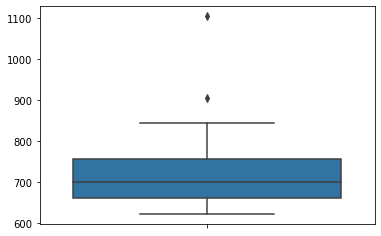

In [35]:
# text length all English re-response
print(text_length(prof_prize[(prof_prize['language']=='English')]['re-response'].to_list(), 
                  'prof_prize_english_box_re-response.png', 'English'))

[528.23, 6.09]


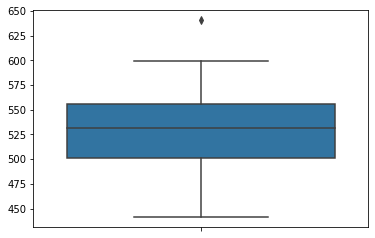

In [36]:
# text length all German re-response
print(text_length(prof_prize[(prof_prize['language']=='German')]['re-response'].to_list(), 
                  'prof_prize_german_box_re-response.png', 'German'))

[756.1, 5.35]


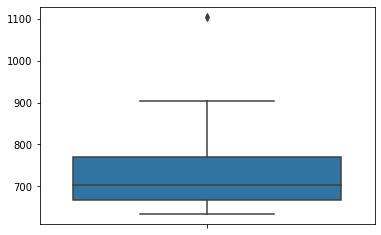

In [37]:
# text length English female re-response
print(text_length(response_slicer(prof_prize, 'English', 'female', 're-response'), 
                  'prof_prize_box_english_female_re-response.png', 'English'))

[698.1, 5.38]


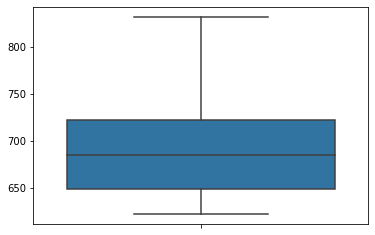

In [38]:
# text length English male re-response
print(text_length(response_slicer(prof_prize, 'English', 'male', 're-response'), 
                  'prof_prize_box_english_male_re-response.png', 'English'))

[715.3, 5.61]


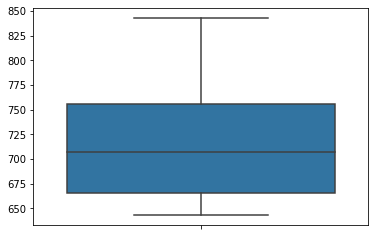

In [39]:
# text length English neutral re-response
print(text_length(response_slicer(prof_prize, 'English', 'neutral', 're-response'), 
                  'prof_prize_box_english_neutral_re-response.png', 'English'))

[525.8, 6.15]


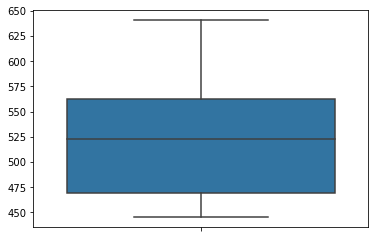

In [40]:
# text length German female re-response
print(text_length(response_slicer(prof_prize, 'German', 'female', 're-response'), 
                  'prof_prize_box_german_female_re-response.png', 'German'))

[525.7, 6.12]


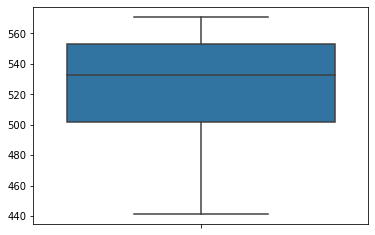

In [41]:
# text length German male re-response
print(text_length(response_slicer(prof_prize, 'German', 'male', 're-response'), 
                  'prof_prize_box_german_male_re-response.png', 'German'))

[533.2, 5.99]


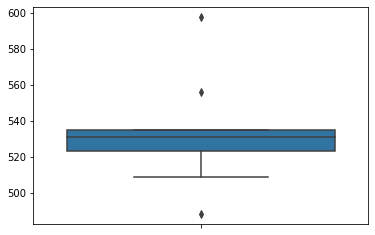

In [42]:
# text length German neutral re-response
print(text_length(response_slicer(prof_prize, 'German', 'neutral', 're-response'), 
                  'prof_prize_box_german_neutral_re-response.png', 'German'))

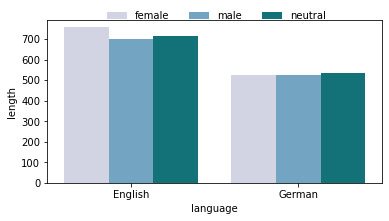

In [43]:
data_re_response = [['re-response', 'English', 'female', 756], ['re-response', 'English', 'male', 698], ['re-response', 'English', 'neutral', 715],
                    ['re-response', 'German', 'female', 526], ['re-response', 'German', 'male', 526], ['re-response', 'German', 'neutral', 533]]
legths_re_response_frame = pd.DataFrame(data_re_response, columns=['type', 'language', 'perspective', 'length'])

fig, ax = plt.subplots(figsize=(6, 3))

length = sns.barplot(data=legths_re_response_frame, x="language", y="length", hue="perspective", palette="PuBuGn", ax=ax)
sns.move_legend(length, "upper left", bbox_to_anchor=(0.15, 1.11), ncol=3, title=None, frameon=False,)

figure = length.get_figure()
figure.savefig('prof_prize_re-response_bar.png')

### Gender-Coded Adjectives

In [6]:
# female words English

frames_english_prof_prize = [frame_builder('female', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'female', 're-response'), female_adjectives_english)), 
          frame_builder('male', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'male', 're-response'), female_adjectives_english)),
          frame_builder('neutral', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'neutral', 're-response'), female_adjectives_english))]
num_female_adjectives_english_prof_prize = pd.concat(frames_english_prof_prize)
num_female_adjectives_english_prof_prize = num_female_adjectives_english_prof_prize[num_female_adjectives_english_prof_prize.overall != 0.0]
display(num_female_adjectives_english_prof_prize)

,word,overall,used,perspective,language
4,collab,1.4,1.56,female,English
5,commit,4.6,4.60,female,English
30,nurtur,1.4,1.75,female,English
34,respon,0.1,1.00,female,English
37,support,2.2,2.44,female,English
40,together,0.1,1.00,female,English
42,understand,1.7,1.89,female,English
45,enthusias,0.2,1.00,female,English
46,inclusive,1.2,1.33,female,English
48,share,0.2,1.00,female,English


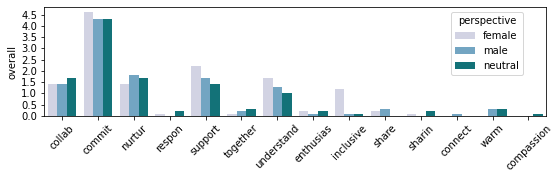

In [12]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_prof_prize = sns.barplot(data=num_female_adjectives_english_prof_prize, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_prof_prize.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))


figure_prof_prize = overall_prof_prize.get_figure()
figure_prof_prize.savefig('prof_prize_overall_num_female_adjectives_english_bar.png', bbox_inches="tight")

In [13]:
# female words German

frames_german_prof_prize = [frame_builder('female', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'female', 're-response'), female_adjectives_german)), 
          frame_builder('male', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'male', 're-response'), female_adjectives_german)),
          frame_builder('neutral', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'neutral', 're-response'), female_adjectives_german))]
num_female_adjectives_german_prof_prize = pd.concat(frames_german_prof_prize)
num_female_adjectives_german_prof_prize = num_female_adjectives_german_prof_prize[num_female_adjectives_german_prof_prize.overall != 0.0]
display(num_female_adjectives_german_prof_prize)

,word,overall,used,perspective,language
4,betreu,0.1,1.00,female,German
7,dankbar,0.2,1.00,female,German
12,engag,3.0,3.33,female,German
15,förder,1.1,2.20,female,German
21,gemeinschaft,2.2,2.20,female,German
25,herzlich,1.0,1.11,female,German
35,miteinander,0.1,1.00,female,German
44,team,0.4,1.33,female,German
45,treu,0.1,1.00,female,German
49,unterstütz,0.5,1.25,female,German


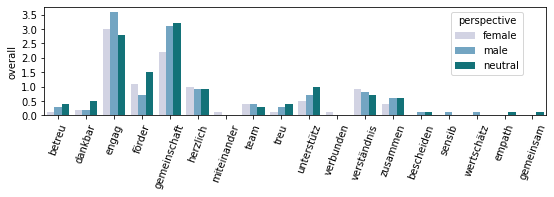

In [14]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=70)
plt.yticks(np.arange(0, 5, 0.5))
overall_prof_prize = sns.barplot(data=num_female_adjectives_german_prof_prize, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_prof_prize.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_prof_prize = overall_prof_prize.get_figure()
figure_prof_prize.savefig('prof_prize_overall_num_female_adjectives_german_bar.png', bbox_inches="tight")

In [15]:
# male words English

frames_english_male_prof_prize = [frame_builder('female', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'female', 're-response'), male_adjectives_english)), 
          frame_builder('male', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'male', 're-response'), male_adjectives_english)),
          frame_builder('neutral', 'English', average_word_usage(response_slicer(prof_prize, 'English', 'neutral', 're-response'), male_adjectives_english))]
num_male_adjectives_english_prof_prize = pd.concat(frames_english_male_prof_prize)
num_male_adjectives_english_prof_prize = num_male_adjectives_english_prof_prize[num_male_adjectives_english_prof_prize.overall != 0.0]
display(num_male_adjectives_english_prof_prize)

,word,overall,used,perspective,language
0,active,0.6,1.00,female,English
3,ambitio,0.1,1.00,female,English
4,analy,0.1,1.00,female,English
10,challeng,0.7,1.17,female,English
11,champion,0.2,1.00,female,English
13,confident,0.1,1.00,female,English
14,courag,0.8,1.33,female,English
19,determin,0.2,1.00,female,English
20,domina,0.1,1.00,female,English
22,driven,0.2,1.00,female,English


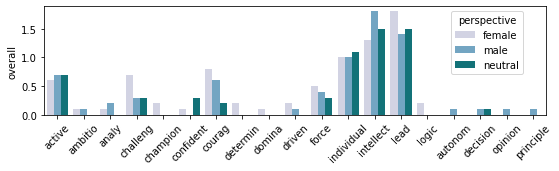

In [16]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_prof_prize = sns.barplot(data=num_male_adjectives_english_prof_prize, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_prof_prize.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_prof_prize = overall_prof_prize.get_figure()
figure_prof_prize.savefig('prof_prize_overall_num_male_adjectives_english_bar.png', bbox_inches="tight")

In [17]:
# male words German

frames_german_prof_prize = [frame_builder('female', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'female', 're-response'), male_adjectives_german)), 
          frame_builder('male', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'male', 're-response'), male_adjectives_german)),
          frame_builder('neutral', 'German', average_word_usage(response_slicer(prof_prize, 'German', 'neutral', 're-response'), male_adjectives_german))]
num_male_adjectives_german_prof_prize = pd.concat(frames_german_prof_prize)
num_male_adjectives_german_prof_prize = num_male_adjectives_german_prof_prize[num_male_adjectives_german_prof_prize.overall != 0.0]
display(num_male_adjectives_german_prof_prize)

,word,overall,used,perspective,language
8,beharr,0.1,1.00,female,German
14,ehrgeiz,0.1,1.00,female,German
17,einfluss,1.7,2.12,female,German
23,führ,1.9,2.38,female,German
24,gewinn,0.7,1.17,female,German
29,konkurr,0.1,1.00,female,German
32,leisten,0.3,1.50,female,German
35,leit,0.4,1.33,female,German
37,mutig,0.9,1.29,female,German
47,stark,0.2,1.00,female,German


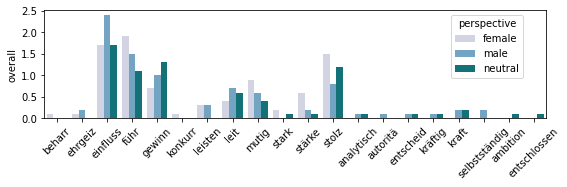

In [18]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_prof_prize = sns.barplot(data=num_male_adjectives_german_prof_prize, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_prof_prize.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_prof_prize = overall_prof_prize.get_figure()
figure_prof_prize.savefig('prof_prize_overall_num_male_adjectives_german_bar.png', bbox_inches="tight")

## Analysis "Characteristics of a Good Professor" Prompt

In [80]:
# show good prof data

good_prof.head()

,ID,language,perspective,date,prompt,response
0,0,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess..."
1,1,English,female,2023-06-09,What is a good female professor?,"A good female professor, much like any good pr..."
2,2,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess..."
3,3,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess..."
4,4,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess..."


In [19]:
# preprocessing

good_prof.loc[(good_prof['language']=='English'),'response_pre-processed'] = good_prof[(good_prof['language']=='English')]['response'].apply(lambda text: preprocessing_english(text))
good_prof.loc[(good_prof['language']=='German'),'response_pre-processed'] = good_prof[(good_prof['language']=='German')]['response'].apply(lambda text: preprocessing_german(text))


good_prof.head()

,ID,language,perspective,date,prompt,response,response_pre-processed
0,0,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess...","A good female professor , like good professor ..."
1,1,English,female,2023-06-09,What is a good female professor?,"A good female professor, much like any good pr...","A good female professor , much like good profe..."
2,2,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess...","A good female professor , like good professor ..."
3,3,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess...","A good female professor , like good professor ..."
4,4,English,female,2023-06-09,What is a good female professor?,"A good female professor, like any good profess...","A good female professor , like good professor ..."


### Text Length

[438.87, 5.18]


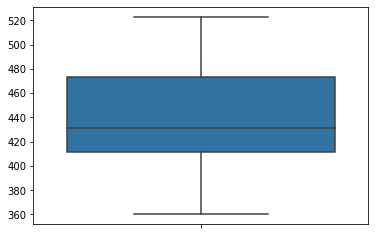

In [44]:
# text length all English response
print(text_length(good_prof[(good_prof['language']=='English')]['response'].to_list(), 'good_prof_english_box_response.png', 'English'))

[353.57, 5.54]


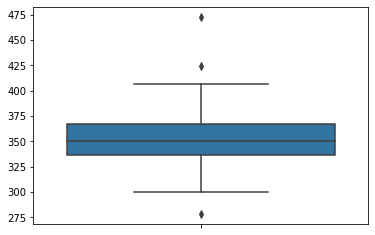

In [45]:
# text length all German response
print(text_length(good_prof[(good_prof['language']=='German')]['response'].to_list(), 'good_prof_german_box_response.png', 'German'))

[425.1, 5.17]


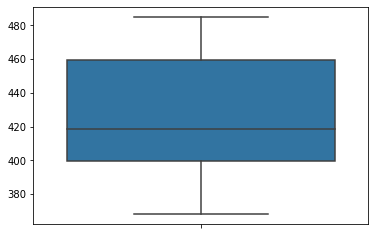

In [46]:
# text length English female response
print(text_length(response_slicer(good_prof, 'English', 'female', 'response'), 
                  'good_prof_box_english_female_response.png', 'English'))

[435.7, 5.17]


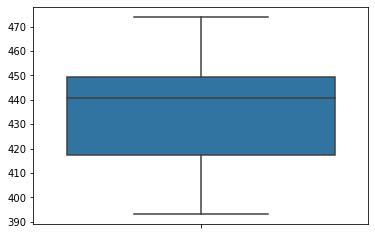

In [47]:
# text length English male response
print(text_length(response_slicer(good_prof, 'English', 'male', 'response'), 
                  'good_prof_box_english_male_response.png', 'English'))

[455.8, 5.21]


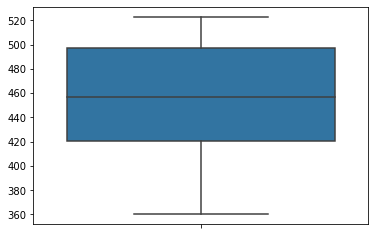

In [48]:
# text length English neutral response
print(text_length(response_slicer(good_prof, 'English', 'neutral', 'response'), 
                  'good_prof_box_english_neutral_response.png', 'English'))

[339.4, 5.78]


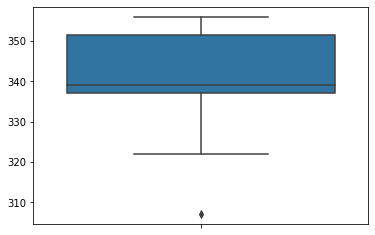

In [50]:
# text length German female response
print(text_length(response_slicer(good_prof, 'German', 'female', 'response'), 
                  'good_prof_box_german_female_response.png', 'German'))

[333.1, 5.61]


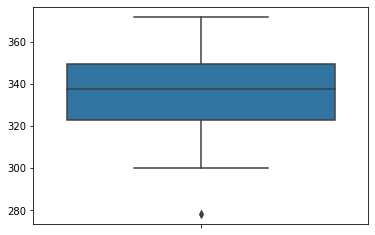

In [51]:
# text length German male response
print(text_length(response_slicer(good_prof, 'German', 'male', 'response'), 
                  'good_prof_box_german_male_response.png', 'German'))

[388.2, 5.24]


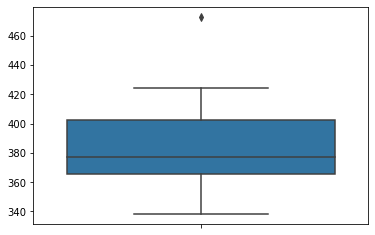

In [52]:
# text length German neutral response
print(text_length(response_slicer(good_prof, 'German', 'neutral', 'response'), 
                  'good_prof_box_german_neutral_response.png', 'German'))

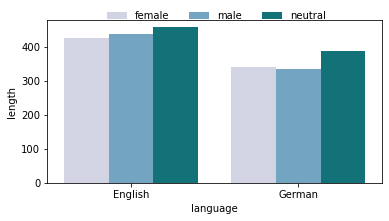

In [53]:
data_response = [['response', 'English', 'female', 425], ['response', 'English', 'male', 436], ['response', 'English', 'neutral', 456],
                 ['response', 'German', 'female', 339], ['response', 'German', 'male', 333], ['response', 'German', 'neutral', 388]]
legths_response_frame = pd.DataFrame(data_response, columns=['type', 'language', 'perspective', 'length'])

fig, ax = plt.subplots(figsize=(6, 3))

length = sns.barplot(data=legths_response_frame, x="language", y="length", hue="perspective", palette="PuBuGn", ax=ax)
sns.move_legend(length, "upper left", bbox_to_anchor=(0.15, 1.11), ncol=3, title=None, frameon=False,)

figure = length.get_figure()
figure.savefig('good_prof_response_bar.png')

### Gender-Coded Adj

In [20]:
# female words English

frames_english_good_prof = [frame_builder('female', 'English', average_word_usage(response_slicer(good_prof, 'English', 'female', 'response'), female_adjectives_english)), 
          frame_builder('male', 'English', average_word_usage(response_slicer(good_prof, 'English', 'male', 'response'), female_adjectives_english)),
          frame_builder('neutral', 'English', average_word_usage(response_slicer(good_prof, 'English', 'neutral', 'response'), female_adjectives_english))]
num_female_adjectives_english_good_prof = pd.concat(frames_english_good_prof)
num_female_adjectives_english_good_prof = num_female_adjectives_english_good_prof[num_female_adjectives_english_good_prof.overall != 0.0]
display(num_female_adjectives_english_good_prof)

,word,overall,used,perspective,language
4,collab,0.1,1.00,female,English
5,commit,1.2,1.71,female,English
8,connect,0.1,1.00,female,English
13,emotiona,0.1,1.00,female,English
14,empath,1.2,2.00,female,English
15,feel,1.1,1.38,female,English
29,nag,0.2,2.00,female,English
30,nurtur,0.1,1.00,female,English
37,support,2.6,2.60,female,English
42,understand,2.1,2.33,female,English


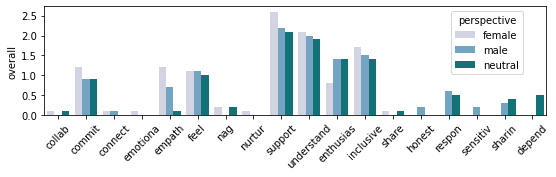

In [21]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_good_prof = sns.barplot(data=num_female_adjectives_english_good_prof, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_good_prof.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_good_prof = overall_good_prof.get_figure()
figure_good_prof.savefig('good_prof_overall_num_female_adjectives_english_bar.png', bbox_inches="tight")

In [22]:
# female words German

frames_german_good_prof = [frame_builder('female', 'German', average_word_usage(response_slicer(good_prof, 'German', 'female', 'response'), female_adjectives_german)), 
          frame_builder('male', 'German', average_word_usage(response_slicer(good_prof, 'German', 'male', 'response'), female_adjectives_german)),
          frame_builder('neutral', 'German', average_word_usage(response_slicer(good_prof, 'German', 'neutral', 'response'), female_adjectives_german))]
num_female_adjectives_german_good_prof = pd.concat(frames_german_good_prof)
num_female_adjectives_german_good_prof = num_female_adjectives_german_good_prof[num_female_adjectives_german_good_prof.overall != 0.0]
display(num_female_adjectives_german_good_prof)

,word,overall,used,perspective,language
4,betreu,0.3,1.00,female,German
8,ehrlich,0.1,1.00,female,German
11,empath,0.6,2.00,female,German
12,engag,2.1,2.10,female,German
15,förder,1.5,1.88,female,German
21,gemeinschaft,0.7,2.33,female,German
22,gruppe,0.1,1.00,female,German
24,helfen,0.4,2.00,female,German
26,hilf,0.2,1.00,female,German
44,team,0.1,1.00,female,German


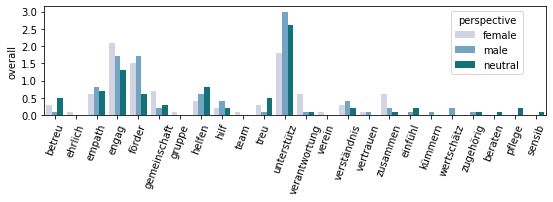

In [23]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=70)
plt.yticks(np.arange(0, 5, 0.5))
overall_good_prof = sns.barplot(data=num_female_adjectives_german_good_prof, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_good_prof.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_good_prof = overall_good_prof.get_figure()
figure_good_prof.savefig('good_prof_overall_num_female_adjectives_german_bar.png', bbox_inches="tight")

In [24]:
# male words English

frames_english_good_prof = [frame_builder('female', 'English', average_word_usage(response_slicer(good_prof, 'English', 'female', 'response'), male_adjectives_english)), 
          frame_builder('male', 'English', average_word_usage(response_slicer(good_prof, 'English', 'male', 'response'), male_adjectives_english)),
          frame_builder('neutral', 'English', average_word_usage(response_slicer(good_prof, 'English', 'neutral', 'response'), male_adjectives_english))]
num_male_adjectives_english_good_prof = pd.concat(frames_english_good_prof)
num_male_adjectives_english_good_prof = num_male_adjectives_english_good_prof[num_male_adjectives_english_good_prof.overall != 0.0]
display(num_male_adjectives_english_good_prof)

,word,overall,used,perspective,language
0,active,1.1,1.38,female,English
10,challeng,0.7,1.00,female,English
12,compet,0.3,1.00,female,English
14,courag,2.3,2.30,female,English
19,determin,0.3,1.00,female,English
33,individual,0.1,1.00,female,English
35,lead,0.4,2.00,female,English
37,objective,0.1,1.00,female,English
38,opinion,0.1,1.00,female,English
41,principle,0.1,1.00,female,English


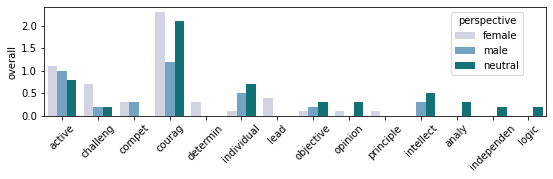

In [25]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_good_prof = sns.barplot(data=num_male_adjectives_english_good_prof, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_good_prof.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1))

figure_good_prof = overall_good_prof.get_figure()
figure_good_prof.savefig('good_prof_overall_num_male_adjectives_english_bar.png', bbox_inches="tight")

In [26]:
# male words German

frames_german_good_prof = [frame_builder('female', 'German', average_word_usage(response_slicer(good_prof, 'German', 'female', 'response'), male_adjectives_german)), 
          frame_builder('male', 'German', average_word_usage(response_slicer(good_prof, 'German', 'male', 'response'), male_adjectives_german)),
          frame_builder('neutral', 'German', average_word_usage(response_slicer(good_prof, 'German', 'neutral', 'response'), male_adjectives_german))]
num_male_adjectives_german_good_prof = pd.concat(frames_german_good_prof)
num_male_adjectives_german_good_prof = num_male_adjectives_german_good_prof[num_male_adjectives_german_good_prof.overall != 0.0]
display(num_male_adjectives_german_good_prof)

,word,overall,used,perspective,language
20,entscheid,0.1,1.00,female,German
23,führ,0.1,1.00,female,German
31,kraft,0.2,1.00,female,German
35,leit,0.2,1.00,female,German
37,mutig,0.6,1.00,female,German
47,stark,0.1,1.00,female,German
48,stärke,0.2,1.00,female,German
10,bestimmt,0.1,1.00,male,German
23,führ,0.1,1.00,male,German
31,kraft,0.1,1.00,male,German


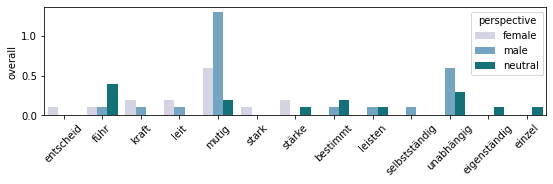

In [27]:
fig, ax = plt.subplots(figsize=(9, 2))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 5, 0.5))
overall_good_prof = sns.barplot(data=num_male_adjectives_german_good_prof, x="word", y="overall", hue="perspective", palette="PuBuGn", ax=ax)
overall_good_prof.set(xlabel=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.84, 1))

figure_good_prof = overall_good_prof.get_figure()
figure_good_prof.savefig('good_prof_overall_num_male_adjectives_german_bar.png', bbox_inches="tight")